# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
# Import packages and data --> check the head of data table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, anderson
from scipy import stats

df = pd.read_csv('data/human_body_temperature.csv')
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [2]:
# Number of observations
df.shape[0]

130

### Is the distribution of body temperatures normal? 

In [3]:
# Function for Empirical Cummulative Distribution Function (ECDF)
def ecdf(col):
    import numpy as np
    x = np.sort(col)
    y = np.arange(1, len(x) + 1) / len(x)
    return(x, y)

In [4]:
# Randon sample with mean and standard deviation from df
mean = np.mean(df.temperature)
std = np.std(df.temperature)
np.random.seed(2018)
samples = np.random.normal(mean, std, size = 10000)

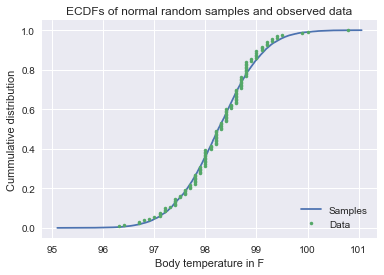

In [5]:
# ECDFs from df and samples --> plots using the defualt seaborn setting
x, y = ecdf(df.temperature)
x_theor, y_theor = ecdf(samples)

sns.set()
_ = plt.plot(x_theor, y_theor, label = 'Samples')
_ = plt.plot(x, y, marker = '.', linestyle = 'none', label = 'Data')
_ = plt.xlabel('Body temperature in F')
_ = plt.ylabel('Cummulative distribution')
_ = plt.title('ECDFs of normal random samples and observed data')
_ = plt.legend(loc = 'lower right')
plt.show()

In [6]:
# Shapiro-Wilk test
stat, p = shapiro(df.temperature)
print('Statistics: %.3f \np: %.3f' % (stat, p))

# interpretation
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics: 0.987 
p: 0.233
Sample looks Gaussian (fail to reject H0)


In [7]:
# Anderson-Darling test
result = anderson(df.temperature)
print('Statistic: %.3f' % result.statistic)

# Interpretation
print('\nsignificance_level: critical_value')
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%18.1f: %14.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%18.1f: %14.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 0.520

significance_level: critical_value
              15.0:          0.560, data looks normal (fail to reject H0)
              10.0:          0.637, data looks normal (fail to reject H0)
               5.0:          0.765, data looks normal (fail to reject H0)
               2.5:          0.892, data looks normal (fail to reject H0)
               1.0:          1.061, data looks normal (fail to reject H0)


From the ECDFs, we assume that the observed data come from normally distributed population as the data points are well set on the line of the randomly generated normal samples.  Addition to this, we conducted two normality tests, namely Shapiro-Wilk and Anderson_Darling - they tell us that the observed datset is normally distributed at any confidence levels that we are usually considered in statistics.

### Is the sample size large? Are the observations independent?

The sample size of 130 is regarded as a sufficiently large enough to implement statistical testing for hypotheses.  Under the assumption of no one attended multiple times to measure their temperatures, the data are regarded as independent since one person's temperature does not affect to others.

### Is the true population mean really 98.6 degrees F? 

In [8]:
# Bootstrap hypothesis test
# H0: our data came from the poputation mean of 98.6F
pop_mean = 98.6
sample_mean = np.mean(df.temperature)
num_reps = 100000 # number of replicates we draw

def draw_bs_reps(data, func, size = 1): # Function for bootstrap replicates
    bs_replicates = np.empty(size)
    
    for i in range(size):
        bs_sample = np.random.choice(data, len(data))
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

bs_reps = draw_bs_reps(df.temperature, np.mean, num_reps) # draw replicates

p = np.sum(bs_reps >= pop_mean) / num_reps # compute p-value
print('Probaility of observation or extreme under the null hypothesis: ', p)

Probaility of observation or extreme under the null hypothesis:  0.0


Under the assumption of the null hypothesis, the probability of the observation or more extreme cases is 0 from the bootstrap hypothsis test. So we can conclude that the our data did not come from the population with mean temperture of 98.6F.

In [9]:
# Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why? 
# One-sample test as we have only one dataset: t-test as we don't know the population SD
mu = 98.6
sample_mean = np.mean(df.temperature)
standard_error = np.std(df.temperature)
num_samples = len(df.temperature) # number of samples
t_score = (sample_mean - mu) / (standard_error / np.sqrt(num_samples)) # t-score for the sample
p = stats.t.cdf(t_score, df = num_samples - 1)
print('p-value from t-score: ', p)

p-value from t-score:  1.0943732312047587e-07


In [10]:
# Now try using the other test. How is the result be different? Why? 
z_score = t_score
p= stats.norm.cdf(z_score)
print('p-value from z-score: ', p)

p-value from z-score:  2.1761575829410943e-08


The p-values from t-test and z-test are very close each other, but not exactly same; this is because that z-distribution has lighter tails comparing ones of t-distribution. When we compute the probobility of the extreme observations, tail weights effect the p-value. As a result, the p-value from the t-test has smaller value than one form t-test. 

### Draw a small sample of size 10 from the data and repeat both frequentist tests. 

In [11]:
# Draw a sample of ten elements with replacement
np.random.seed(2018)
size_10_samp = np.random.choice(df.temperature, 10)
size_10_samp

array([98. , 98.6, 98. , 98. , 98.8, 99.1, 98.6, 96.9, 98.2, 97.9])

In [12]:
# t-test
mu = 98.6
sample_mean = np.mean(size_10_samp)
standard_error = np.std(size_10_samp)
num_samples = len(size_10_samp) 
t_score = (sample_mean - mu) / (standard_error / np.sqrt(num_samples)) # t-score for the sample
p = stats.t.cdf(t_score, df = num_samples - 1)
print('p-value from t-score: ', p)

p-value from t-score:  0.0315956024996138


In [13]:
# z-test
z_score = t_score
p= stats.norm.cdf(z_score)
print('p-value from z-score: ', p)

p-value from z-score:  0.01706629935621105


Both of these p-values are significantly greater than those from the earlier excise, with 150 observations. Also the p-value from t-test is larger, in almost double, than it from z-test. This is due to the small sample size, and we should take the t-test rather than z-test in this case.

### At what temperature should we consider someone's temperature to be "abnormal"? 

In [14]:
# Replicates bootstrap sampling for mean --> computes confidence interval with 3se
num_reps = 100000 # number of replicates we draw

def draw_bs_reps(data, func, size = 1): # Function for bootstrap replicates
    bs_replicates = np.empty(size)
    
    for i in range(size):
        bs_sample = np.random.choice(data, len(data))
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

bs_reps = draw_bs_reps(df.temperature, np.mean, num_reps) # draw replicates

mean = np.mean(bs_reps) # mean of the replicated sample means
se = np.std(bs_reps) # standard error of the replicated sample means
margin_of_error = se * 3 # set the margin of error with 3*se (as regarded in general)
ci = [mean - margin_of_error, mean + margin_of_error] # confidence interval within three standard errors
p = np.sum((bs_reps <= ci[0] ) | (bs_reps >= ci[1])) / num_reps # p-value of ether sides of extremes

print('Confidence interval within 3se: ', ci, '\nProbaility of observation outside ci: ', p)

Confidence interval within 3se:  [98.0582127202945, 98.44097934124397] 
Probaility of observation outside ci:  0.00289


From the bootstrap replicates above, we can say that someone having under 98.1F or above 98.4F should be regarded as too-low or -high temperatures, respectively.  These cases lie outside of three standard errors with the probability of less than 0.003 from our simulation.

### Is there a significant difference between males and females in normal temperature?

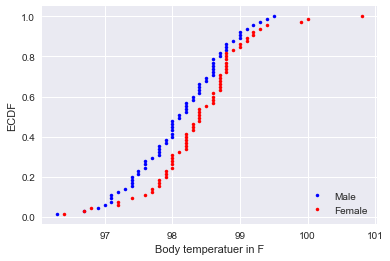

In [15]:
# What testing approach did you use and why? 
# H0: Male and female have the same mean temperature
# Create two subsets, one for male and the other for femal 
# EDA first

temp_m = df[df.gender == 'M'].temperature # 65 obs for male
temp_f = df[df.gender == 'F'].temperature # 65 obs fro female

x_male, y_male = ecdf(temp_m) # ecdf: defined earlier
x_female, y_female = ecdf(temp_f)

_ = plt.plot(x_male, y_male, marker = '.', linestyle = 'none', color = 'blue')
_ = plt.plot(x_female, y_female, marker = '.', linestyle = 'none', color = 'red')
_ = plt.xlabel('Body temperatuer in F')
_ = plt.ylabel('ECDF')
_ = plt.legend(['Male', 'Female'], loc = 'lower right')
plt.show()

In [16]:
# Use two-sample bootstrap  hypothsis test since we have two sets of data for male and female

temp_concat = np.concatenate((temp_m, temp_f)) # concatenate two sets
num_reps = 100000 # number of replicates

def diff_of_means(data1, data2): # function for compute the mean difference
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    
    return mean1 - mean2

obs_diff_mean = diff_of_means(temp_m, temp_f) # mean difference from out observation: -0.29

bs_diff_means = np.empty(num_reps) # initialise the array

for i in range(num_reps): # impliments bootstrap replicates for the mean difference
    bs_temp = np.random.choice(temp_concat, len(temp_concat))
    bs_diff_means[i] = diff_of_means(bs_temp[:len(temp_m)], bs_temp[len(temp_m):])

p = np.sum(bs_diff_means <= obs_diff_mean) / num_reps
print('p-value of mean difference: ', p)

p-value of mean difference:  0.01207


In [17]:
# Mean difference of body temperatures from the observation
obs_diff_mean

-0.289230769230727

From the bootstrap hypothsis test for the mean difference between gender, we can say that there is a significant difference in the mean temparature in the male and female - the body temperature of female is 0.29F higher than male's from the observed dataset.

In [18]:
# Write a story with your conclusion in the context of the original problem.

In conclusion, Carl Wunderlich's dataset seems to be different from the general belief of the body temperature of 98.6F according to our a number of hypothsis tests, such as bootstrapping, t-test and z-test. His data averaged 98.2F which is 0.4F lower than the normal knowledge.  Also, his data shows that the mean temperatuers between gender are significantly different. 